In [ ]:
# Use this code if pull commands does not work
#%rm -rf /content/drive/My\ Drive/Colab\ Notebooks/DEEP_LEARNING_DTU/project/\02456_l2rpn/
#%cd /content/drive/My\ Drive/Colab\ Notebooks/DEEP_LEARNING_DTU/project/
#!git clone https://github.com/jmontalvo94/02456_l2rpn.git
#!git pull

/content/drive/My Drive/Colab Notebooks/DEEP_LEARNING_DTU/project/02456_l2rpn
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/jmontalvo94/02456_l2rpn
   5df8195..57fe4f7  main       -> origin/main
Updating 5df8195..57fe4f7
Fast-forward
 agent_emil.py | 2 ++
 1 file changed, 2 insertions(+)


In [ ]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/jmontalvo94/02456_l2rpn
   e7402c8..5327d3a  main       -> origin/main
Updating e7402c8..5327d3a
Fast-forward
 agent_emil.py | 26 +++++++++++---------------
 1 file changed, 11 insertions(+), 15 deletions(-)


In [1]:
# %cd /content/drive/My\ Drive/Colab\ Notebooks/DEEP_LEARNING_DTU/project/\02456_l2rpn/

# !pip install grid2op

import agent_emil as agent 
import grid2op
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grid2op.Chronics import GridStateFromFileWithForecasts
from grid2op.Agent import DoNothingAgent,RandomAgent,PowerLineSwitch,AgentWithConverter
from grid2op.Action import DontAct,PowerlineChangeAction,TopologySetAction,TopologyChangeAction
from grid2op.PlotGrid import PlotMatplot
from grid2op.Parameters import Parameters
from grid2op.Converter import IdToAct,Converter
from grid2op.Reward import FlatReward
from itertools import product
from tqdm.notebook import tqdm 

# CREATE ENVIROMENT

In [2]:
p = Parameters()
# Disable lines disconnections due to overflows
# p.NO_OVERFLOW_DISCONNECTION = True
# Allow many steps with overflow
# p.NB_TIMESTEP_OVERFLOW_ALLOWED = 1 # Default is 2
# No waiting time to reconnect
# p.NB_TIMESTEP_RECONNECTION = 0
# No authomatic disconnection
# p.HARD_OVERFLOW_THRESHOLD = 9999

env = grid2op.make('rte_case14_realistic',
                   action_class=TopologyChangeAction,
                   param=p)

# For reproducibility
env.seed(0)

# Chronic ID and number of episodes
CHRONIC_ID = 000
episode_count = 100 

##### CUSTOM-MADE FUNCTIONS TO CONVERT GRID2OP ACTION TO ONE HOT ENCODING ACTION

In [3]:
n_powerlines = 20
n_substations = 14
total_bus_actions = 56

def create_one_hot_converter(n_powerlines,n_substations,total_bus_actions):
  """
  Creates two 2-d np.arrays used for conversion between grid2op action to one hot encoding action vector used by a neural network
  """
  one_hot_encoding_act_conv = []
  env_act_dict_list = []
  zero_act = np.zeros((n_powerlines+total_bus_actions,1))

  ## Add do nothing action vector (all zeroes)
  one_hot_encoding_act_conv.append(zero_act)
  env_act_dict_list.append({}) ## {} is the do nothing dictonary for actions in grid2op

  ## Powerline change actions
  for idx in range(n_powerlines):
    one_hot_encoding_act_conv_pwline = zero_act.copy()
    one_hot_encoding_act_conv_pwline[total_bus_actions+idx] = 1
    one_hot_encoding_act_conv.append(one_hot_encoding_act_conv_pwline)
    env_act_dict_list.append({'change_line_status': [idx]}) ## {'change_line_status': [idx]} set an action of changing line status for lineid with id idx


  ## Bus change actions
  start_slice = 0
  for sub_station_id, nb_el in enumerate(env.action_space.sub_info):
    one_hot_encoding_act_conv_substation = zero_act.copy()

    possible_bus_actions = np.array(list(product('01', repeat=nb_el))).astype(int)
    for possible_bus_action in possible_bus_actions:
      if possible_bus_action.sum()>0: # Do not include no change action vector
        one_hot_encoding_act_conv_substation[start_slice:(start_slice+nb_el)] = possible_bus_action.reshape(-1,1)
        one_hot_encoding_act_conv.append(one_hot_encoding_act_conv_substation.copy())
        env_act_dict_list.append({"change_bus": {"substations_id": [(sub_station_id, possible_bus_action.astype(bool))]}})
    start_slice += nb_el

  one_hot_encoding_act_conv = np.array(one_hot_encoding_act_conv).reshape(len(one_hot_encoding_act_conv),n_powerlines+total_bus_actions)

  return one_hot_encoding_act_conv,env_act_dict_list

def convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act):
  """
  Converts an grid2op action (in numpy format) to a one hot encoding vector
  """
  one_hot_encoding_act = np.zeros(len(one_hot_encoding_act_conv))
  env_act = env_act.reshape(-1,)
  action_idx = (one_hot_encoding_act_conv[:, None] == env_act).all(-1).any(-1)
  one_hot_encoding_act[action_idx] = 1
  return one_hot_encoding_act

def convert_one_hot_encoding_act_to_env_act(env_act_dict_list,one_hot_encoding_act,env=env):
  """
  Converts a one hot encoding action to a grid2op action
  """
  return env.action_space(env_act_dict_list[tmp_.argmax().item()])

##### SANITY CHECKS OF WHETHER CUSTOM MADE CONVERSIONS WORK

In [4]:
one_hot_encoding_act_conv,env_act_dict_list = create_one_hot_converter(n_powerlines,n_substations,total_bus_actions)

my_agent = RandomAgent(env.action_space)
all_obs = []
obs = env.reset()
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
action = my_agent.act(obs, reward, done)
#print(action.to_vect()[:56])
#print(action.to_vect()[-20:])
print("Action directly from grid2op")
print(action)
#print(action.to_dict())
tmp_ = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act=action.to_vect())
my_action = convert_one_hot_encoding_act_to_env_act(env_act_dict_list,tmp_)
print("Action converted to one hot encoding and back to grid2op action. Should be the same as above")
print(my_action)

Action directly from grid2op
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 2 [on substation 1]
	 	 - switch bus of generator 0 [on substation 1]
	 - NOT force any particular bus configuration
Action converted to one hot encoding and back to grid2op action. Should be the same as above
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 2 [on substation 1]
	 	 - switch bus of generator 0 [on substation 1]
	 - NOT force any particular bus configuration


# PRE-BUILT AGENT: DO NOTHING AGENT

In [10]:
env.chronics_handler.max_timestep()

8064

In [5]:
my_agent = DoNothingAgent(env.action_space)
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Do Nothing Agent Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:

    # env.set_id(CHRONIC_ID)
    # ob = env.reset()

    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_do_nothing_agent = np.copy(reward_list)
print(nb_step)


Do Nothing Agent Simulation



1094


In [ ]:
reward_list_do_nothing_agent

array([1., 1., 1., ..., 1., 1., 0.], dtype=float32)

# PRE-BUILT AGENT: RANDOM ACTION AGENT

In [6]:
my_agent = RandomAgent(env.action_space)
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Random Agent Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:

    # env.set_id(CHRONIC_ID)
    # ob = env.reset()
    
    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_random_agent = np.copy(reward_list)


Random Agent Simulation


# PRE-BUILT AGENT: POWER SWITCH AGENT

In [7]:
env_all_actions_available = grid2op.make('rte_case14_realistic',
                   reward_class=FlatReward,
                   param=p)
my_agent = PowerLineSwitch(env_all_actions_available.action_space)
all_obs = []
obs = env_all_actions_available.reset()
all_obs.append(obs)
reward = env_all_actions_available.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Power Line Switch Agent Simulation")
with tqdm(total=env_all_actions_available.chronics_handler.max_timestep()) as pbar:

    # env.set_id(CHRONIC_ID)
    # ob = env.reset()

    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env_all_actions_available.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_power_line_switch_agent = np.copy(reward_list)


Power Line Switch Agent Simulation


# GRAPHICAL COMPARISON OF PRE-BUILT AGENTS

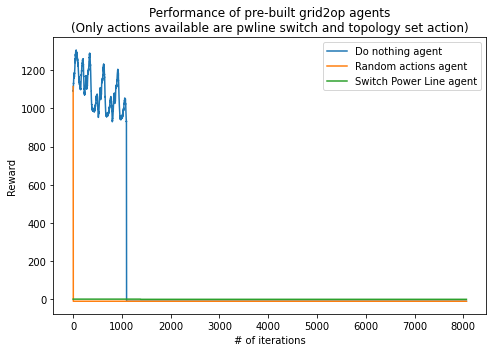

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

nested_lists = [reward_list_do_nothing_agent,reward_list_random_agent,reward_power_line_switch_agent]
lists_to_df  = []

for nested_list in  nested_lists:
  len_list = len(nested_list)
  final_value = nested_list[-1]
  list_ = np.repeat(final_value,env.chronics_handler.max_timestep())
  list_[:len_list] = nested_list
  lists_to_df.append(list_)

df_pre_built_agents = pd.DataFrame(lists_to_df)\
.transpose()\
.rename(columns={0:'do_nothing_agent',1:'random_agent',2:'switch_power_line_agent'})\
.stack()\
.reset_index()\
.rename(columns={'level_0':'iteration','level_1':'agent_type',0:'reward'})


fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.lineplot(x='iteration',y='reward',hue='agent_type',ax=ax,data=df_pre_built_agents)
ax.set_xlabel("# of iterations")
ax.set_ylabel("Reward")
ax.set_title("Performance of pre-built grid2op agents\n(Only actions available are pwline switch and topology set action)")
ax.legend(['Do nothing agent','Random actions agent','Switch Power Line agent'])
plt.tight_layout()
plt.show()
# df_pre_built_agents = pd.DataFrame({'random_agent':reward_list_random_agent,
#                                     'power_line_switch_agent':reward_power_line_switch_agent
#                                     })
# df_pre_built_agents

# SIMPLE DQN

In [ ]:
import torch 

load_qdn_from_network = True
prefix_NN_weight_files = 'dec_2_'

def act_vect_to_act_obj(env, Q_est):
  """
  This function returns a grid2op action object based on the estimated Q-value vector.
  It operates as follows:
  1. Identifies whether a' (action that maximizes Q function is positive).
  2. if a' is non-positive, do nothing action is returned
  3. if a' positive a grid2op action with line change of a' is returned.   

  Arguments:

  env: grid2op enviroment

  Q_est: torch array
  - Estimated Q-value function 

  Returns
  a: grid2op action object
  """

  ## Fix potential nan values
  Q_est[Q_est!=Q_est] = -1
  a_argmax = Q_est.argmax()

  # Check if a' is above zero
  if Q_est.max()>0:
    line_id = Q_est.argmax().item()
    a = env.action_space({'change_line_status': [line_id]}) # Change line status of line with line_id
  else:
    a = env.action_space({}) # Do nothing

  return a

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"

# num_episodes = 2000
# episode_limit = 100
# batch_size = 64
# learning_rate = 0.005
# gamma = 0.99 # discount rate
# tau = 0.01 # target network update rate
# replay_memory_capacity = 10000
# prefill_memory = True
# double_dqn = False
# val_freq = 100 # validation frequency

one_hot_encoding_act_conv,env_act_dict_list = create_one_hot_converter(n_powerlines,n_substations,total_bus_actions)

TRAINING_PARAMS = {
    'num_episodes':2500,
    'episode_limit':env.chronics_handler.max_timestep(),
    'batch_size':64,
    'replay_memory_capacity':20000,
    'prefil_memory':True,
    'val_freq':100,
    'tau':0.01,
    'gamma':0.99,
    'episilon_decay':'Linear' # 'Linear' or 'Exponential'
}

NN_PARAMS = {
    'n_inputs':env.observation_space.n,
    'n_outputs':len(one_hot_encoding_act_conv),
    'n_hidden_layers':3,
    'n_hidden_units':[300,300,300],
    'relu':True,
    'optimizer':'SGD',
    'learning_rate':0.005,
    'weight_decay':0.001
}

# n_inputs = env.observation_space.n
# n_outputs = env.action_space.n

# initialize DQN and replay memory

  
policy_dqn = agent.DQN(NN_PARAMS)
target_dqn = agent.DQN(NN_PARAMS)

if load_qdn_from_network:
  target_dqn.load_state_dict(torch.load('checkpoint_target_dqn.pth'))
  policy_dqn.load_state_dict(torch.load('checkpoint_policy_dqn.pth'))

# set to cuda if available
policy_dqn = policy_dqn.to(dev)
target_dqn = target_dqn.to(dev)

replay_memory = agent.ReplayMemory(TRAINING_PARAMS['replay_memory_capacity'])

# prefill replay memory with random actions
if TRAINING_PARAMS['prefil_memory']:
    print('prefill replay memory')
    s = env.reset()
    with tqdm(total=TRAINING_PARAMS['replay_memory_capacity']) as pbar:
      while replay_memory.count() < TRAINING_PARAMS['replay_memory_capacity']:
          a = env.action_space.sample()
          s1, r, d, _ = env.step(a)
          a_one_hot = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act=a.to_vect())
          replay_memory.add(s.to_vect(), a_one_hot, r, s1.to_vect(), d)
          s = s1 if not d else env.reset()
          pbar.update(1)

# Fix issue with replay_memory not saving states and actions as vectors in some cases (legacy)
# for i,sample_ in enumerate(replay_memory.memory):
#   for j in [0,1,3]:
#     try:
#       ss_ = sample_[j].to_vect()
#       replay_memory[i][j] = ss_
#     except:
#       pass

# training loop
try:
    print('start training')
    epsilon = 1.0
    rewards, lengths, losses, epsilons, game_overs, action_ids = [], [], [], [], [], []
    for i in range(TRAINING_PARAMS['num_episodes']):
        # init new episode
        s, ep_reward, ep_loss,ep_game_over = env.reset(), 0, 0, False
        action_ids_episode = []
        for j in range(TRAINING_PARAMS['episode_limit']):
            # select action with epsilon-greedy strategy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    Q_est = policy_dqn(torch.from_numpy(np.array(s.to_vect(),dtype='float32')).to(dev).float())
                    Q_est[Q_est!=Q_est] = -1 ## Fix potentional na value
                    a = env.action_space(env_act_dict_list[Q_est.argmax().item()])                  
            # perform action
            s1, r, d, _ = env.step(a)
            # store experience in replay memory
            a_one_hot = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act=a.to_vect())
            replay_memory.add(s.to_vect(), a_one_hot, r, s1.to_vect(), d)
            # batch update
            if replay_memory.count() >= TRAINING_PARAMS['batch_size']:
                # sample batch from replay memory
                batch = np.array(replay_memory.sample(TRAINING_PARAMS['batch_size']))
                ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
                # do forward pass of batch
                policy_dqn.optimizer.zero_grad()
                #Q = policy_dqn(torch.from_numpy(one_hot(ss, n_inputs)).float())
                Q = policy_dqn(torch.from_numpy(np.array(ss.tolist(),dtype='float32')).to(dev).float())
                # use target network to compute target Q-values
                with torch.no_grad():
                      # TODO: use target net
                      Q1 = target_dqn(torch.from_numpy(np.array(ss1.tolist(),dtype='float32')).to(dev).float())
                # compute target for each sampled experience
                q_targets = Q.clone()
                for k in range(TRAINING_PARAMS['batch_size']):
                    q_targets[k, aa[k]] = rr[k] + TRAINING_PARAMS['gamma'] * Q1[k].max().item() * (not dd[k])
                # update network weights
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                policy_dqn.optimizer.step()
                # update target network parameters from policy network parameters
                target_dqn.update_params(policy_dqn.state_dict(), TRAINING_PARAMS['tau'])
            else:
                loss = 0
            # bookkeeping
            s = s1
            ep_reward += r
            action_ids_episode.append(a_one_hot.argmax().item())
            try: ep_loss += loss.item()
            except: ep_loss += loss
            if r==-10:
              ep_game_over = True
            if d: break

        # Update epsilon
        if TRAINING_PARAMS['episilon_decay']=='Linear':
          epsilon = 1 - i / TRAINING_PARAMS['num_episodes'] 
        elif TRAINING_PARAMS['episilon_decay']=='Exponential':
          epsilon *= TRAINING_PARAMS['num_episodes']/(i/(TRAINING_PARAMS['num_episodes']/20)+TRAINING_PARAMS['num_episodes']) # decrease epsilon
        
        # bookkeeping
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss);game_overs.append(ep_game_over);action_ids.append(action_ids_episode)
        if (i+1) % TRAINING_PARAMS['val_freq'] == 0:
          print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-TRAINING_PARAMS['val_freq']:])))
          print(f"{i+1} mean survival length: {np.mean(lengths[-TRAINING_PARAMS['val_freq']:])}")
          print(f"{i+1} Best survival length: {np.max(lengths[-TRAINING_PARAMS['val_freq']:])}")
          torch.save(policy_dqn.state_dict(), prefix_NN_weight_files+'checkpoint_policy_dqn.pth')
          torch.save(target_dqn.state_dict(), prefix_NN_weight_files+'checkpoint_target_dqn.pth')
          #print(f"{i+1} mean survival rate (not game over): {1-np.mean(game_overs[-TRAINING_PARAMS['val_freq']:])}%")
    print('done')
except KeyboardInterrupt:
    print('interrupt')



prefill replay memory



start training
  100 mean training reward:  1.28
100 mean survival length: 2.28
100 Best survival length: 6
  200 mean training reward:  1.55
200 mean survival length: 2.55
200 Best survival length: 7
  300 mean training reward:  1.25
300 mean survival length: 2.25
300 Best survival length: 7
  400 mean training reward:  1.40
400 mean survival length: 2.4
400 Best survival length: 6
  500 mean training reward:  1.81
500 mean survival length: 2.81
500 Best survival length: 8
  600 mean training reward:  1.55
600 mean survival length: 2.55
600 Best survival length: 8
  700 mean training reward:  1.62
700 mean survival length: 2.62
700 Best survival length: 10
  800 mean training reward:  1.79
800 mean survival length: 2.79
800 Best survival length: 10
  900 mean training reward:  2.09
900 mean survival length: 3.09
900 Best survival length: 10
 1000 mean training reward:  2.32
1000 mean survival length: 3.32
1000 Best survival length: 10
 1100 mean training reward:  3.01
1100 mean survi

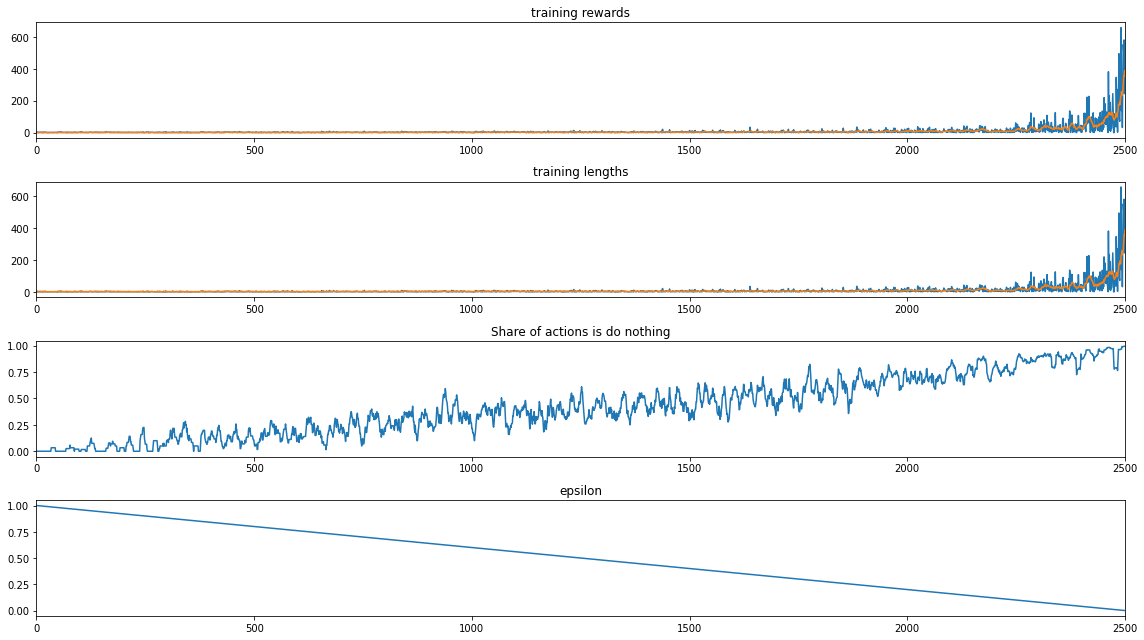

In [ ]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

shr_play_nothing = [(np.array(action_ids_eps)==0).mean() for action_ids_eps in action_ids]

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, len(rewards)+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, len(rewards)])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, len(rewards)+1), lengths)
plt.plot(range(1, len(rewards)+1), moving_average(lengths))
plt.xlim([0, len(rewards)])
#plt.subplot(413)
# plt.title('training loss')
# plt.plot(range(1, len(rewards)+1), losses)
# plt.plot(range(1, len(rewards)+1), moving_average(losses))
# plt.xlim([0, len(rewards)])
plt.subplot(413)
plt.title('Share of actions is do nothing')
plt.plot(range(1, len(shr_play_nothing)+1), moving_average(shr_play_nothing,n=10))
plt.xlim([0, len(shr_play_nothing)])
plt.tight_layout()
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, len(rewards)+1), epsilons)
plt.xlim([0, len(rewards)])
plt.tight_layout()
plt.savefig('double_dqn_training.pdf',dpi=600)
plt.show()

# VERY SIMPLE DQN AGENT

In [15]:
import torch

NN_PARAMS = {
    'n_inputs':env.observation_space.n,
    'n_outputs':len(one_hot_encoding_act_conv),
    'n_hidden_layers':3,
    'n_hidden_units':[300,300,300],
    'relu':True,
    'optimizer':'SGD',
    'learning_rate':0.005,
    'weight_decay':0.001
}

if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu"

policy_dqn = agent.DQN(NN_PARAMS)
target_dqn = agent.DQN(NN_PARAMS)

# Load from drive
target_dqn.load_state_dict(torch.load('checkpoint_target_dqn.pth', map_location=torch.device('cpu')))
policy_dqn.load_state_dict(torch.load('checkpoint_policy_dqn.pth', map_location=torch.device('cpu')))

all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("DQN Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:
    while True:
        #action = act_vect_to_act_obj(env,target_dqn(torch.from_numpy(np.array(obs.to_vect(),dtype='float32')).to(dev).float()))
        #action = my_agent.act(obs, reward, done)
        Q_est = policy_dqn(torch.from_numpy(np.array(obs.to_vect(),dtype='float32')).to(dev).float())
        #Q_est[Q_est!=Q_est] = -1 ## Fix potentional na value
        action = env.action_space(env_act_dict_list[Q_est.argmax().item()])            
        obs, reward, done, _ = env.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_simple_DQN = np.copy(reward_list)


DQN Simulation


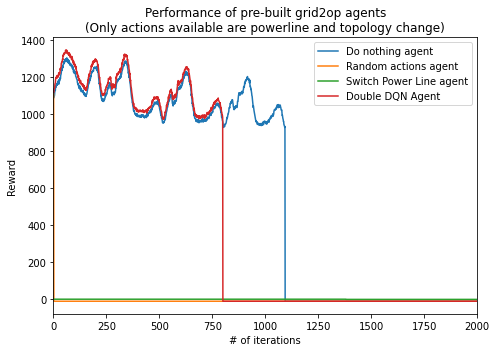

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

nested_lists = [reward_list_do_nothing_agent,reward_list_random_agent,reward_power_line_switch_agent,reward_list_simple_DQN]
lists_to_df  = []

for nested_list in  nested_lists:
  len_list = len(nested_list)
  final_value = nested_list[-1]
  list_ = np.repeat(final_value,env.chronics_handler.max_timestep())
  list_[:len_list] = nested_list
  lists_to_df.append(list_)

df_pre_built_agents = pd.DataFrame(lists_to_df)\
.transpose()\
.rename(columns={0:'do_nothing_agent',1:'random_agent',2:'switch_power_line_agent',3:'Very Simple DQN agent'})\
.stack()\
.reset_index()\
.rename(columns={'level_0':'iteration','level_1':'agent_type',0:'reward'})


fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.lineplot(x='iteration',y='reward',hue='agent_type',ax=ax,data=df_pre_built_agents)
ax.set_xlabel("# of iterations")
ax.set_ylabel("Reward")
ax.set_title("Performance of pre-built grid2op agents\n(Only actions available are powerline and topology change)")
ax.legend(['Do nothing agent','Random actions agent','Switch Power Line agent','Double DQN Agent'])
ax.set_xlim(0,2000)
plt.tight_layout()
plt.show()

# df_pre_built_agents = pd.DataFrame({'random_agent':reward_list_random_agent,
#                                     'power_line_switch_agent':reward_power_line_switch_agent
#                                     })
# df_pre_built_agents

In [17]:
from grid2op.Runner import Runner

NB_EPISODE = 1  # assess the performance for 10 episodes, for example
NB_CORE = 1  # do it on 2 cores, for example
PATH_SAVE = "ddqn"  # and store the results in the "agents_log" folder
runner = Runner(**env.get_params_for_runner(), agentClass=DoNothingAgent)

In [18]:
runner.run(nb_episode=NB_EPISODE, nb_process=NB_CORE, path_save=PATH_SAVE)

[('/home/jorge/data_grid2op/rte_case14_realistic/chronics/000',
  '000',
  888427.5,
  799,
  8064)]